# **REKOM Results**

By:

**Chariz Dianne Falco**

**Mauricio Manuel Bergancia**

**Mark Andrei Encanto**

**Mherlie Joy Chavez**

**Rhazel Jay Gumacal**

In [40]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For enhanced visualizations
import numpy as np

print("Libraries imported successfully.")

Libraries imported successfully.


**Loading the Dataset**

In [41]:
# Load the datasets
try:
    movies = pd.read_csv('movies.dat', sep='::', engine='python',
                         names=['MovieID', 'Title', 'Genres'], encoding='latin-1')
    ratings = pd.read_csv('ratings.dat', sep='::', engine='python',
                          names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='latin-1')
    users = pd.read_csv('users.dat', sep='::', engine='python',
                        names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='latin-1')

    print("\nMovieLens 1M datasets loaded successfully.")

except FileNotFoundError:
    print("Error: Ensure 'movies.dat', 'ratings.dat', and 'users.dat' are in the same directory.")
    print("Please download the MovieLens 1M dataset if you haven't already.")
    # Create empty DataFrames to prevent further errors if files are missing
    movies = pd.DataFrame(columns=['MovieID', 'Title', 'Genres'])
    ratings = pd.DataFrame(columns=['UserID', 'MovieID', 'Rating', 'Timestamp'])
    users = pd.DataFrame(columns=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])


# Display initial dataframes to show successful loading
print("\n--- First 5 rows of 'movies' DataFrame ---")
display(movies.head())

print("\n--- First 5 rows of 'ratings' DataFrame ---")
display(ratings.head())

print("\n--- First 5 rows of 'users' DataFrame ---")
display(users.head())



MovieLens 1M datasets loaded successfully.

--- First 5 rows of 'movies' DataFrame ---


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy



--- First 5 rows of 'ratings' DataFrame ---


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291



--- First 5 rows of 'users' DataFrame ---


,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


**Data Preprocessing - Calculating Average Ratings**

In [42]:
# Merge movies and ratings to link movie metadata with ratings
movie_ratings = pd.merge(movies, ratings, on='MovieID')

# Calculate the mean rating and the count of ratings for each movie
avg_ratings = movie_ratings.groupby(['MovieID', 'Title', 'Genres']).agg({'Rating': ['mean', 'count']})
avg_ratings.columns = ['AverageRating', 'RatingCount'] # Rename columns for clarity
avg_ratings = avg_ratings.reset_index() # Reset index to make MovieID, Title, Genres regular columns

print("Average ratings and rating counts calculated for each movie.")

print("\n--- First 5 rows of 'avg_ratings' DataFrame ---")
display(avg_ratings.head())

print("\n--- Info on 'avg_ratings' DataFrame ---")
avg_ratings.info()

Average ratings and rating counts calculated for each movie.

--- First 5 rows of 'avg_ratings' DataFrame ---


,MovieID,Title,Genres,AverageRating,RatingCount
0,1,Toy Story (1995),Animation|Children's|Comedy,4.146846,2077
1,2,Jumanji (1995),Adventure|Children's|Fantasy,3.201141,701
2,3,Grumpier Old Men (1995),Comedy|Romance,3.016736,478
3,4,Waiting to Exhale (1995),Comedy|Drama,2.729412,170
4,5,Father of the Bride Part II (1995),Comedy,3.006757,296



--- Info on 'avg_ratings' DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3706 entries, 0 to 3705
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MovieID        3706 non-null   int64  
 1   Title          3706 non-null   object 
 2   Genres         3706 non-null   object 
 3   AverageRating  3706 non-null   float64
 4   RatingCount    3706 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 144.9+ KB


**Content-Based Filtering - TF-IDF Vectorization**

In [43]:
# Initialize TF-IDF Vectorizer.
# token_pattern=r'[^|]+' is used to split genres by the '|' delimiter.
tfidf = TfidfVectorizer(token_pattern=r'[^|]+')

# Fit and transform the 'Genres' column of the movies DataFrame
# This converts genre strings into a matrix of TF-IDF features
tfidf_matrix = tfidf.fit_transform(movies['Genres'])

print("TF-IDF Vectorization of movie genres complete.")

print("\n--- Shape of TF-IDF matrix (movies x unique genres) ---")
print(tfidf_matrix.shape) # Expected: (number of movies, number of unique genres)

print("\n--- Example TF-IDF vector for the first movie (sparse representation) ---")
print(tfidf_matrix[0])

# To see some actual features/terms that TF-IDF learned:
print("\n--- Top 10 TF-IDF features (genres) ---")
print(tfidf.get_feature_names_out()[:10])

TF-IDF Vectorization of movie genres complete.

--- Shape of TF-IDF matrix (movies x unique genres) ---
(3883, 18)

--- Example TF-IDF vector for the first movie (sparse representation) ---
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (1, 18)>
  Coords	Values
  (0, 2)	0.7289010463348881
  (0, 3)	0.5917143302654576
  (0, 4)	0.34435071658181016

--- Top 10 TF-IDF features (genres) ---
['action' 'adventure' 'animation' "children's" 'comedy' 'crime'
 'documentary' 'drama' 'fantasy' 'film-noir']


**Content-Based Filtering - Cosine Similarity**

In [44]:
# Compute the cosine similarity between every movie's TF-IDF vector
# linear_kernel is faster than cosine_similarity for dense matrices if you only need the dot product
# which is equivalent to cosine similarity for normalized vectors.
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

print("Cosine Similarity matrix computed.")

print("\n--- Shape of Cosine Similarity matrix (movies x movies) ---")
print(cosine_sim.shape) # Expected: (number of movies, number of movies)

print("\n--- Sample of Cosine Similarity matrix (first 5x5 values) ---")
# Displaying as a DataFrame for better readability
display(pd.DataFrame(cosine_sim[:5, :5],
                     index=movies['Title'].head(5),
                     columns=movies['Title'].head(5)))

# Create a Series that maps MovieID to its index in the movies DataFrame
# This is crucial for quickly looking up a movie's position for similarity calculations
movie_indices = pd.Series(movies.index, index=movies['MovieID'])

print("\n--- Sample of movie_indices (mapping MovieID to DataFrame index) ---")
display(movie_indices.head())

Cosine Similarity matrix computed.

--- Shape of Cosine Similarity matrix (movies x movies) ---
(3883, 3883)

--- Sample of Cosine Similarity matrix (first 5x5 values) ---


Title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995)
Title,,,,,
Toy Story (1995),1.000000,0.305525,0.197372,0.260194,0.344351
Jumanji (1995),0.305525,1.000000,0.000000,0.000000,0.000000
Grumpier Old Men (1995),0.197372,0.000000,1.000000,0.433093,0.573172
Waiting to Exhale (1995),0.260194,0.000000,0.433093,1.000000,0.755606
Father of the Bride Part II (1995),0.344351,0.000000,0.573172,0.755606,1.000000



--- Sample of movie_indices (mapping MovieID to DataFrame index) ---


MovieID
1    0
2    1
3    2
4    3
5    4
dtype: int64

**Recommendation Logic - Putting it all together (Simulated)**

### Running ONE example: Action|Adventure genres, with UserID 1 ###

### Starting Recommendation Process for Genres: ['Action', 'Adventure'], UserID: 1 ###

Step 1: Movies filtered by genres (['Action', 'Adventure'])
Number of movies after genre filter: 649


,MovieID,Title,Genres,AverageRating,RatingCount
1,2,Jumanji (1995),Adventure|Children's|Fantasy,3.201141,701
5,6,Heat (1995),Action|Crime|Thriller,3.878723,940
7,8,Tom and Huck (1995),Adventure|Children's,3.014706,68
8,9,Sudden Death (1995),Action,2.656863,102
9,10,GoldenEye (1995),Action|Adventure|Thriller,3.540541,888


C:\Users\chari\AppData\Local\Temp\ipykernel_29160\2942684401.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AverageRating', y='Title', data=top_10_genre_filtered, palette='viridis')


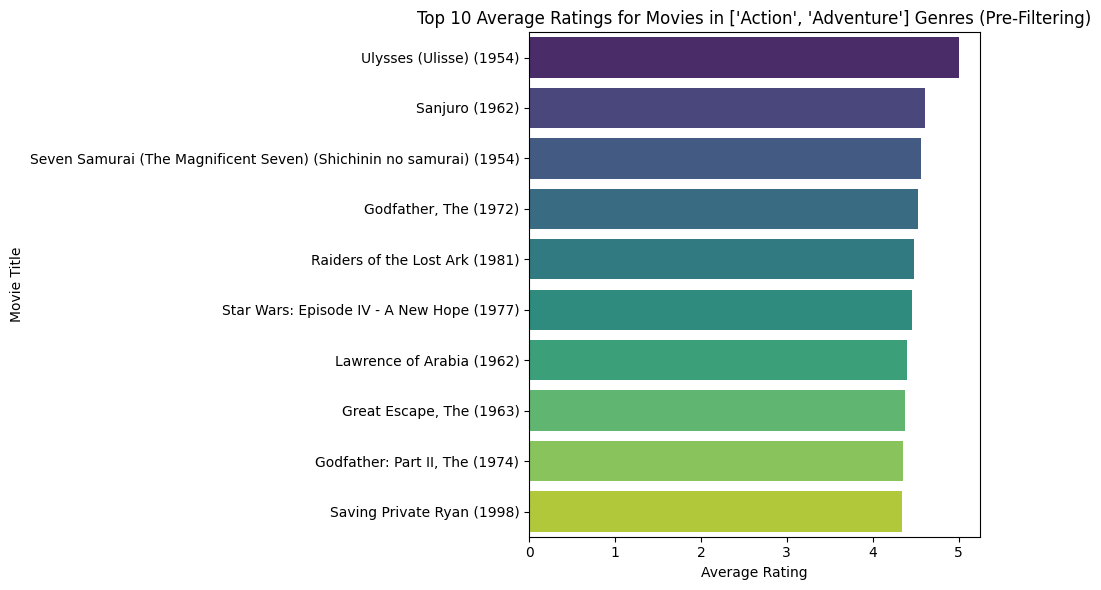


Step 2: Filtered out obscure titles (RatingCount >= 50)
Number of movies after rating count filter: 544


,MovieID,Title,Genres,AverageRating,RatingCount
1,2,Jumanji (1995),Adventure|Children's|Fantasy,3.201141,701
5,6,Heat (1995),Action|Crime|Thriller,3.878723,940
7,8,Tom and Huck (1995),Adventure|Children's,3.014706,68
8,9,Sudden Death (1995),Action,2.656863,102
9,10,GoldenEye (1995),Action|Adventure|Thriller,3.540541,888


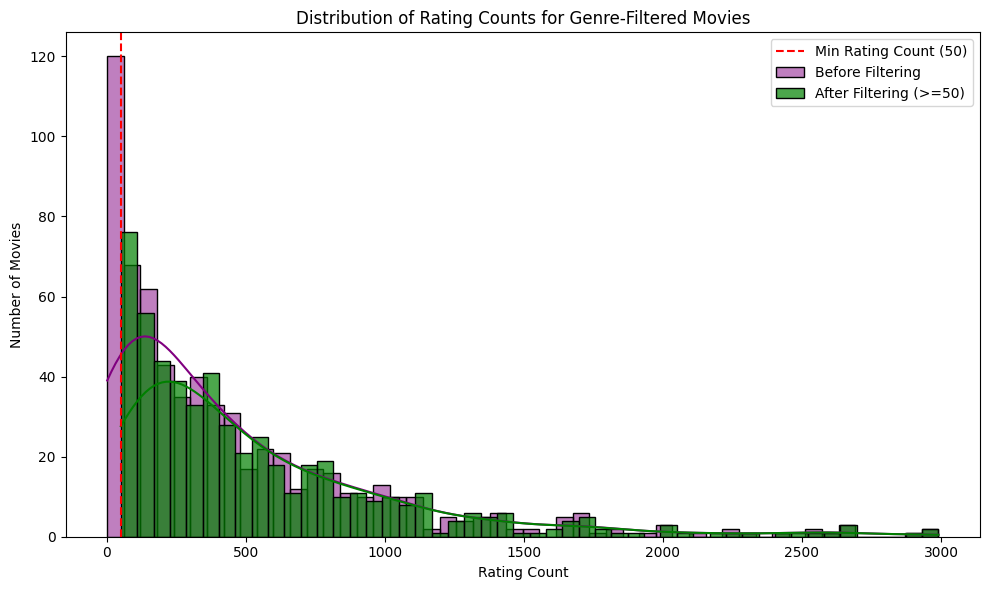


Step 3: Movies sorted by AdjustedRating (for UserID 1)


,Title,AverageRating,Rating_user_group,AdjustedRating
280,Seven Samurai (The Magnificent Seven) (Shichin...,4.560510,5.0,4.780255
156,Lawrence of Arabia (1962),4.401925,5.0,4.700963
172,"Great Escape, The (1963)",4.376437,5.0,4.688218
169,"Treasure of the Sierra Madre, The (1948)",4.289183,5.0,4.644592
413,Sanjuro (1962),4.608696,NaN,4.608696


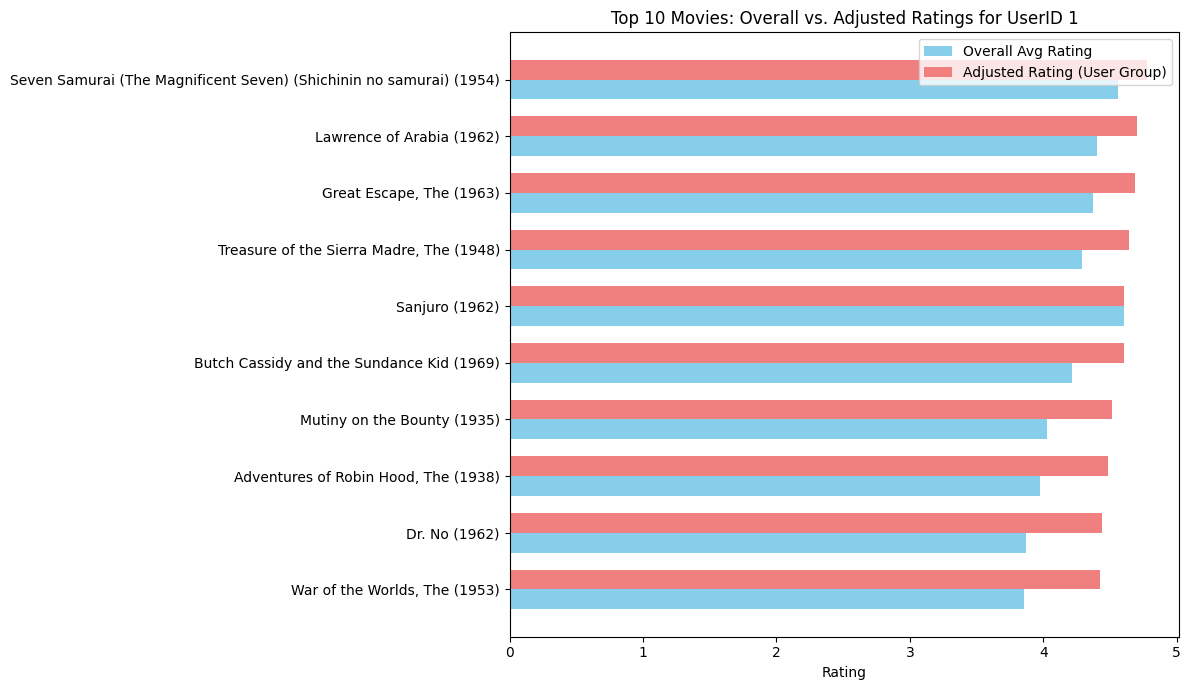


Step 4: Top 10 MovieIDs from initial filtering: [2019 1204 1262 1254 2905 1304 1931  940 2949 2662]


,MovieID,Title,Genres
928,940,"Adventures of Robin Hood, The (1938)",Action|Adventure
1186,1204,Lawrence of Arabia (1962),Adventure|War
1234,1254,"Treasure of the Sierra Madre, The (1948)",Adventure
1242,1262,"Great Escape, The (1963)",Adventure|War
1284,1304,Butch Cassidy and the Sundance Kid (1969),Action|Comedy|Western
1862,1931,Mutiny on the Bounty (1935),Adventure
1950,2019,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama
2593,2662,"War of the Worlds, The (1953)",Action|Sci-Fi|War
2836,2905,Sanjuro (1962),Action|Adventure
2880,2949,Dr. No (1962),Action



Step 5: MovieIDs from content-based similarity to top picks (35 results)
[np.int64(3585), np.int64(2951), np.int64(522), np.int64(1676), np.int64(145), np.int64(20), np.int64(1303), np.int64(1304), np.int64(3366), np.int64(809)]


C:\Users\chari\AppData\Local\Temp\ipykernel_29160\2942684401.py:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_content_sim_movies.values, y=top_10_content_sim_movies.index, palette='plasma')


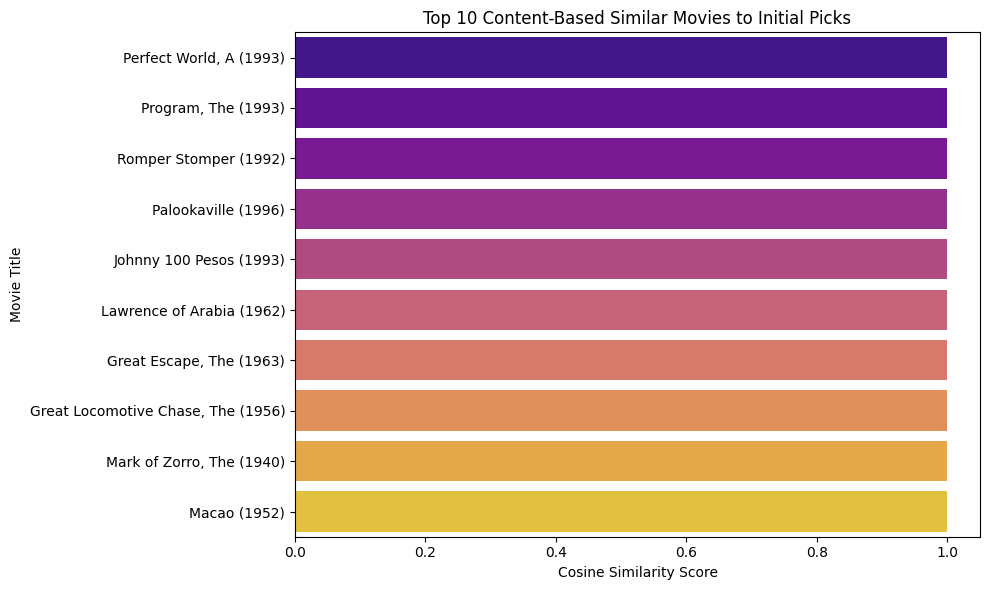


Step 6: Combined and Deduplicated Candidate Movies (39 results)


,MovieID,Title,Genres
19,20,Money Train (1995),Action
70,71,Fair Game (1995),Action
143,145,Bad Boys (1995),Action
202,204,Under Siege 2: Dark Territory (1995),Action
206,208,Waterworld (1995),Action|Adventure



Step 7: Final Top 10 Recommended Movies (10 results)


,Title,Genres,FinalRating
31,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama,4.780255
20,Lawrence of Arabia (1962),Adventure|War,4.700963
22,"Great Escape, The (1963)",Adventure|War,4.688218
21,"Treasure of the Sierra Madre, The (1948)",Adventure,4.644592
33,Sanjuro (1962),Action|Adventure,4.608696
24,Butch Cassidy and the Sundance Kid (1969),Action|Comedy|Western,4.607822
30,Mutiny on the Bounty (1935),Adventure,4.515556
13,"Adventures of Robin Hood, The (1938)",Action|Adventure,4.486772
11,Dr. Strangelove or: How I Learned to Stop Worr...,Sci-Fi|War,4.449890
34,Dr. No (1962),Action,4.437307


C:\Users\chari\AppData\Local\Temp\ipykernel_29160\2942684401.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


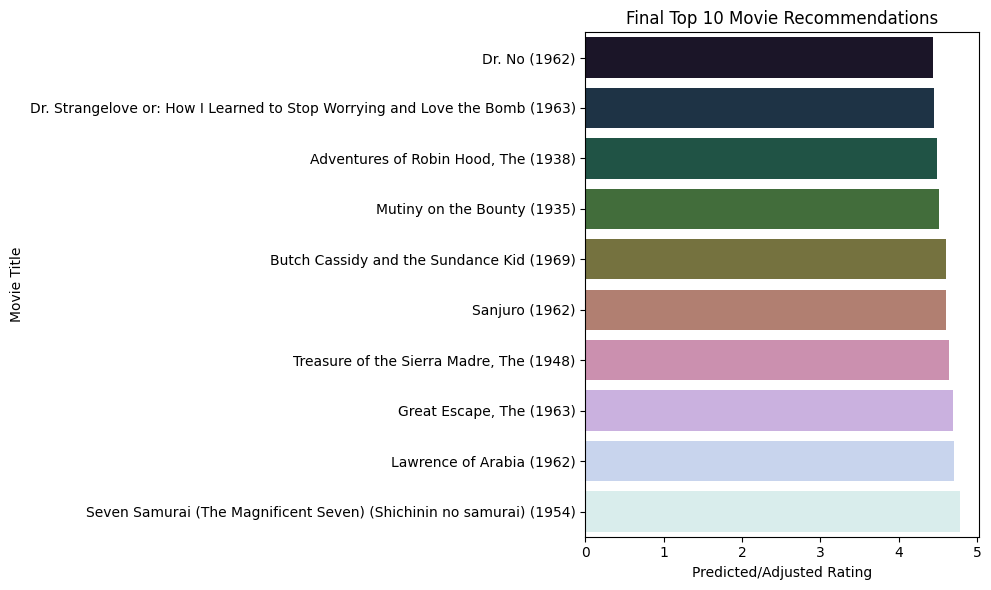


--- Summary of Final Recommendations (Simulated Output) ---
- Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954) (Action|Drama) - Final Score: 4.7803
- Lawrence of Arabia (1962) (Adventure|War) - Final Score: 4.7010
- Great Escape, The (1963) (Adventure|War) - Final Score: 4.6882
- Treasure of the Sierra Madre, The (1948) (Adventure) - Final Score: 4.6446
- Sanjuro (1962) (Action|Adventure) - Final Score: 4.6087
- Butch Cassidy and the Sundance Kid (1969) (Action|Comedy|Western) - Final Score: 4.6078
- Mutiny on the Bounty (1935) (Adventure) - Final Score: 4.5156
- Adventures of Robin Hood, The (1938) (Action|Adventure) - Final Score: 4.4868
- Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) (Sci-Fi|War) - Final Score: 4.4499
- Dr. No (1962) (Action) - Final Score: 4.4373


In [48]:
# Cell 3: Recommendation Logic - Detailed Example with Visualizations (CORRECTED for KeyError)

# This function encapsulates the recommendation logic,
# mimicking how it would process a request based on genres and optionally a user ID.

def get_recommendations_with_plots(genre_list, user_id=None):
    """
    Generates movie recommendations based on specified genres and optionally a user ID,
    with integrated plots to visualize each step of the computation.
    """
    if movies.empty or avg_ratings.empty or 'tfidf_matrix' not in globals() or 'cosine_sim' not in globals():
        print("Error: Required dataframes or matrices are not loaded. Please run all preceding cells.")
        return []

    print(f"\n### Starting Recommendation Process for Genres: {genre_list}, UserID: {user_id} ###")

    # 1. Filter movies by requested genres
    genre_query = "|".join(genre_list)
    genre_filtered_step1 = avg_ratings[avg_ratings['Genres'].str.contains(genre_query, case=False, na=False)].copy()

    print(f"\nStep 1: Movies filtered by genres ({genre_list})")
    print(f"Number of movies after genre filter: {len(genre_filtered_step1)}")
    display(genre_filtered_step1.head())

    # Plot 1: Bar chart of top 10 average ratings for genre-filtered movies
    if not genre_filtered_step1.empty:
        plt.figure(figsize=(10, 6))
        top_10_genre_filtered = genre_filtered_step1.sort_values(by='AverageRating', ascending=False).head(10)
        sns.barplot(x='AverageRating', y='Title', data=top_10_genre_filtered, palette='viridis')
        plt.title(f'Top 10 Average Ratings for Movies in {genre_list} Genres (Pre-Filtering)')
        plt.xlabel('Average Rating')
        plt.ylabel('Movie Title')
        plt.tight_layout()
        plt.show()

    # 2. Filter out obscure titles (e.g., less than 50 ratings)
    genre_filtered_step2 = genre_filtered_step1[genre_filtered_step1['RatingCount'] >= 50].copy()
    print(f"\nStep 2: Filtered out obscure titles (RatingCount >= 50)")
    print(f"Number of movies after rating count filter: {len(genre_filtered_step2)}")
    display(genre_filtered_step2.head())

    if genre_filtered_step2.empty:
        print(f"No movies found for genres {genre_list} with at least 50 ratings after filtering.")
        return []

    # Plot 2: Histogram of RatingCount for genre-filtered movies
    plt.figure(figsize=(10, 6))
    sns.histplot(genre_filtered_step1['RatingCount'], bins=50, kde=True, color='purple', label='Before Filtering')
    sns.histplot(genre_filtered_step2['RatingCount'], bins=50, kde=True, color='green', alpha=0.7, label='After Filtering (>=50)')
    plt.axvline(x=50, color='red', linestyle='--', label='Min Rating Count (50)')
    plt.title('Distribution of Rating Counts for Genre-Filtered Movies')
    plt.xlabel('Rating Count')
    plt.ylabel('Number of Movies')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Incorporate user-based filtering (simplified collaborative filtering aspect)
    current_genre_filtered_df = genre_filtered_step2.copy() # Use a temporary copy for this step's modifications

    # Add a default 'AdjustedRating' which is initially 'AverageRating'
    current_genre_filtered_df['AdjustedRating'] = current_genre_filtered_df['AverageRating']

    if user_id and user_id in users['UserID'].values:
        user_data = users[users['UserID'] == user_id].iloc[0]
        # Find users with similar occupation and gender (simplified similarity)
        similar_users_df = users[
            (users['Occupation'] == user_data['Occupation']) &
            (users['Gender'] == user_data['Gender'])
        ]
        # Get ratings from these similar users
        sim_user_ratings = ratings[ratings['UserID'].isin(similar_users_df['UserID'])]

        if not sim_user_ratings.empty:
            sim_avg_ratings_by_group = sim_user_ratings.groupby('MovieID').agg(GroupRating=('Rating', 'mean')).reset_index()

            # Merge these group-specific average ratings with our genre-filtered movies
            # Use temp column for merge to avoid name conflicts before final AdjustedRating calculation
            current_genre_filtered_df = pd.merge(current_genre_filtered_df, sim_avg_ratings_by_group,
                                                  on='MovieID', how='left')

            if 'GroupRating' in current_genre_filtered_df.columns:
                current_genre_filtered_df.rename(columns={'GroupRating': 'Rating_user_group'}, inplace=True)
                # Adjust overall rating by incorporating the user group's average rating
                # Fill NaN for movies not rated by similar group with the movie's overall AverageRating
                current_genre_filtered_df['AdjustedRating'] = (
                    current_genre_filtered_df['AverageRating'] +
                    current_genre_filtered_df['Rating_user_group'].fillna(current_genre_filtered_df['AverageRating'])
                ) / 2
            else:
                # If no similar user ratings, AdjustedRating remains AverageRating (as initialized)
                print(f"No 'GroupRating' column found after merge. AdjustedRating defaults to AverageRating.")

            current_genre_filtered_df = current_genre_filtered_df.sort_values(by='AdjustedRating', ascending=False)
            print(f"\nStep 3: Movies sorted by AdjustedRating (for UserID {user_id})")
            display(current_genre_filtered_df[['Title', 'AverageRating', 'Rating_user_group', 'AdjustedRating']].head())

            # Plot 3: Comparison of AverageRating vs. AdjustedRating for top movies
            plt.figure(figsize=(12, 7))
            top_10_adjusted = current_genre_filtered_df.head(10).sort_values(by='AdjustedRating', ascending=True) # Sort for plot readability
            bar_width = 0.35
            index = np.arange(len(top_10_adjusted))

            plt.barh(index - bar_width/2, top_10_adjusted['AverageRating'], bar_width, label='Overall Avg Rating', color='skyblue')
            plt.barh(index + bar_width/2, top_10_adjusted['AdjustedRating'], bar_width, label='Adjusted Rating (User Group)', color='lightcoral')
            plt.yticks(index, top_10_adjusted['Title'])
            plt.xlabel('Rating')
            plt.title(f'Top 10 Movies: Overall vs. Adjusted Ratings for UserID {user_id}')
            plt.legend()
            plt.tight_layout()
            plt.show()

        else:
            print(f"No ratings found for similar users to UserID {user_id}. Sorting by AverageRating.")
            current_genre_filtered_df = current_genre_filtered_df.sort_values(by='AverageRating', ascending=False)
            print(f"\nStep 3: Movies sorted by AverageRating (no similar user ratings, for genres)")
            display(current_genre_filtered_df.head())

    else:
        print(f"UserID {user_id} not provided or not found. Sorting by AverageRating.")
        current_genre_filtered_df = current_genre_filtered_df.sort_values(by='AverageRating', ascending=False)
        print(f"\nStep 3: Movies sorted by AverageRating (no UserID or user not found, for genres)")
        display(current_genre_filtered_df.head())

    if current_genre_filtered_df.empty:
        print("No movies remaining after all filtering criteria for recommendation.")
        return []

    # 4. Select top movies from initial filtering (top 10 based on current sorting)
    top_initial_movie_ids = current_genre_filtered_df['MovieID'].head(10).values
    print(f"\nStep 4: Top 10 MovieIDs from initial filtering: {top_initial_movie_ids}")
    top_initial_movies_details = movies[movies['MovieID'].isin(top_initial_movie_ids)][['MovieID', 'Title', 'Genres']]
    display(top_initial_movies_details)

    # 5. Find content-based similar movies to the top initial picks
    similar_movies_from_content_set = set()
    content_sim_scores_for_plot = {} # Store scores for plotting

    if not movie_indices.empty:
        for movie_id in top_initial_movie_ids:
            if movie_id in movie_indices.index:
                idx = movie_indices[movie_id]
                sim_scores = list(enumerate(cosine_sim[idx]))
                sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
                # Get top 5 similar movies, excluding the movie itself
                similar_indices = [i[0] for i in sim_scores[1:6]]
                for s_idx in similar_indices:
                    s_movie_id = movies.iloc[s_idx]['MovieID']
                    s_movie_title = movies.iloc[s_idx]['Title']
                    s_score = cosine_sim[idx, s_idx]
                    similar_movies_from_content_set.add(s_movie_id)
                    # Store max similarity for plotting if a movie is similar to multiple top picks
                    content_sim_scores_for_plot[s_movie_title] = max(content_sim_scores_for_plot.get(s_movie_title, 0), s_score)


    print(f"\nStep 5: MovieIDs from content-based similarity to top picks ({len(similar_movies_from_content_set)} results)")
    print(list(similar_movies_from_content_set)[:10]) # Print first 10 if many

    # Plot 4: Bar chart of top 10 content-similar movies
    if content_sim_scores_for_plot:
        top_10_content_sim_movies = pd.Series(content_sim_scores_for_plot).nlargest(10)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=top_10_content_sim_movies.values, y=top_10_content_sim_movies.index, palette='plasma')
        plt.title('Top 10 Content-Based Similar Movies to Initial Picks')
        plt.xlabel('Cosine Similarity Score')
        plt.ylabel('Movie Title')
        plt.tight_layout()
        plt.show()

    # 6. Combine and deduplicate recommendations
    all_candidate_movie_ids = list(top_initial_movie_ids) + list(similar_movies_from_content_set)
    # Ensure all original movie metadata is retained, including Genres, Title, and MovieID
    final_selection_df = movies[movies['MovieID'].isin(all_candidate_movie_ids)].drop_duplicates().copy()

    print(f"\nStep 6: Combined and Deduplicated Candidate Movies ({len(final_selection_df)} results)")
    display(final_selection_df.head())

    # 7. Final selection (e.g., top 10 unique titles)
    # Merge with `current_genre_filtered_df` to get the 'AdjustedRating' (or 'AverageRating' if no adjustment was made)
    # and also ensure 'AverageRating' is available for comparison/fallback.
    # We will use 'AdjustedRating' if it exists, otherwise 'AverageRating' from `avg_ratings`.

    # First, merge with the current_genre_filtered_df to get the 'AdjustedRating'
    if 'AdjustedRating' not in current_genre_filtered_df.columns:
        current_genre_filtered_df['AdjustedRating'] = current_genre_filtered_df['AverageRating']

    final_selection_df = pd.merge(
        final_selection_df,
        current_genre_filtered_df[['MovieID', 'AdjustedRating']],
        on='MovieID', how='left'
    )

    # Then, merge with the overall avg_ratings to ensure 'AverageRating' is always available
    if 'AverageRating' not in avg_ratings.columns:
        avg_ratings['AverageRating'] = np.nan

    final_selection_df = pd.merge(
        final_selection_df,
        avg_ratings[['MovieID', 'AverageRating']],
        on='MovieID', how='left', suffixes=('_adjusted', '_overall')
    )

    # Determine the 'FinalRating' to sort by
    # Prioritize AdjustedRating if it's not NaN, otherwise use AverageRating_overall
    final_selection_df['FinalRating'] = final_selection_df['AdjustedRating'].fillna(final_selection_df['AverageRating'])

    # Sort by the determined 'FinalRating'
    final_selection_df.sort_values(by='FinalRating', ascending=False, inplace=True)

    # Only select columns that exist
    columns_to_show = [col for col in ['Title', 'Genres', 'FinalRating'] if col in final_selection_df.columns]
    recommended_movies_final = final_selection_df[columns_to_show].head(10)

    print(f"\nStep 7: Final Top 10 Recommended Movies ({len(recommended_movies_final)} results)")
    display(recommended_movies_final)

    # Plot 5: Final Recommended Movies - Bar Chart
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='FinalRating',
        y='Title',
        data=recommended_movies_final.sort_values(by='FinalRating', ascending=True),
        palette='cubehelix'
    )
    plt.title('Final Top 10 Movie Recommendations')
    plt.xlabel('Predicted/Adjusted Rating')
    plt.ylabel('Movie Title')
    plt.tight_layout()
    plt.show()

    result = []
    for _, row in recommended_movies_final.iterrows():
        result.append({
            "title": row.get('Title', ''),
            "genres": row.get('Genres', ''),
            "final_rating": row.get('FinalRating', np.nan)
        })
    return result

# --- Single Demonstration Call with Plots ---

print("### Running ONE example: Action|Adventure genres, with UserID 1 ###")
# UserID 1 is a valid UserID in MovieLens 1M
final_recommendations = get_recommendations_with_plots(genre_list=["Action", "Adventure"], user_id=1)

print("\n--- Summary of Final Recommendations (Simulated Output) ---")
if final_recommendations:
    for movie in final_recommendations:
        print(f"- {movie['title']} ({movie['genres']}) - Final Score: {movie['final_rating']:.4f}")
else:
    print("No recommendations found for this query.")